In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement= Base.classes.measurement
Station=Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

#get last date in data set
last_date = session.query(Measurement.date).\
            order_by(Measurement.date.desc()).first()
#substract 365 days to get the last year date 

date_1year_ago = (dt.datetime.strptime(last_date[0],'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
date_1year_ago


'2016-08-23'

In [20]:
# Perform a query to retrieve the date and precipitation scores
#first find out columns name in measurement 
inspector = inspect(engine)
measurement_columns = inspector.get_columns('measurement')
for column in measurement_columns:
    print(column['name'])

meas_col=(Measurement.date, Measurement.prcp)
#retrive date and prcp value
prcp_last_year = session.query(*meas_col).\
                filter(Measurement.date >= date_1year_ago).all()

id
station
date
prcp
tobs


In [34]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
prcp_df = pd.DataFrame(prcp_last_year)
prcp_df.set_index('date',inplace=True)
prcp_df = prcp_df.sort_index()
prcp_df.head()




,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


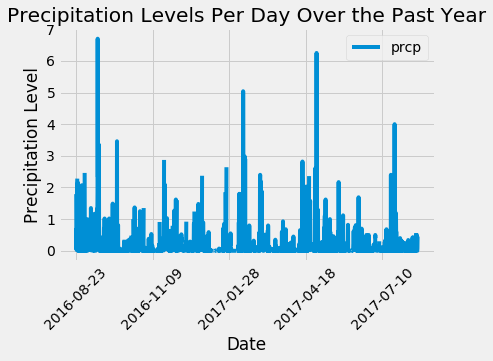

In [40]:
# Use Pandas Plotting with Matplotlib to plot the data
data=prcp_df.plot(rot=45)
data.set_title("Precipitation Levels Per Day Over the Past Year")
data.set_xlabel("Date")
data.set_ylabel("Precipitation Level")
plt.show()

In [41]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [56]:
# Design a query to show how many stations are available in this dataset?
#first find out columns name in measurement 
inspector = inspect(engine)
station_columns = inspector.get_columns('station')
for column in station_columns:
    print(column['name'])

number_of_station=session.query(func.count(Station.id)).all()
number_of_station

id
station
name
latitude
longitude
elevation


[(9)]

In [53]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
Most_active_stations=session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
Most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [52]:
print(f"The most active station is: {Most_active_stations[0]}")

The most active station is: ('USC00519281', 2772)


In [188]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

Min_temp=session.query(func.min(Measurement.tobs)).\
          filter(Measurement.station == 'USC00519281').first()

Max_temp=session.query(func.max(Measurement.tobs)).\
          filter(Measurement.station == 'USC00519281').first()
Avg_temp=session.query(func.avg(Measurement.tobs)).\
          filter(Measurement.station == 'USC00519281').first()


print(f"The lowest temperature recorded is : {Min_temp[0]}.")
print(f"The highest temperature recorded is : {Max_temp[0]}.")
print(f"The average temperature recorded is : {Avg_temp[0]}.")





The lowest temperature recorded is : 54.0.
The highest temperature recorded is : 85.0.
The average temperature recorded is : 71.66378066378067.


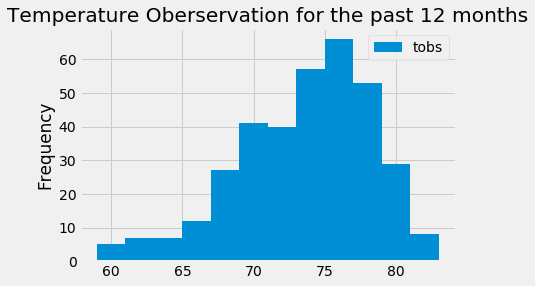

In [104]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
Most_active_data=session.query(Measurement.date,Measurement.tobs).\
                    filter(Measurement.station == 'USC00519281').\
                    filter(Measurement.date >=date_1year_ago).all()
hist=pd.DataFrame(Most_active_data)
hist.plot(kind="hist",bins=12,title="Temperature Oberservation for the past 12 months")
hist.set_xlabel=("Temperature")


## Bonus Challenge Assignment

In [105]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [106]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_start = '2016-06-11'
trip_end = '2016-06-20'


def find_last_year_date(start_date, end_date):
  
    last_year_trip_start = (dt.datetime.strptime(trip_start,'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
    last_year_trip_end = (dt.datetime.strptime(trip_end,'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
    return last_year_trip_start, last_year_trip_end

last_year_trip_start,last_year_trip_end = find_last_year_date(trip_start, trip_end)

tmin, tavg, tmax = calc_temps(last_year_trip_start,last_year_trip_end)[0]
print(tmin, tavg, tmax)

66.0 75.08450704225352 80.0


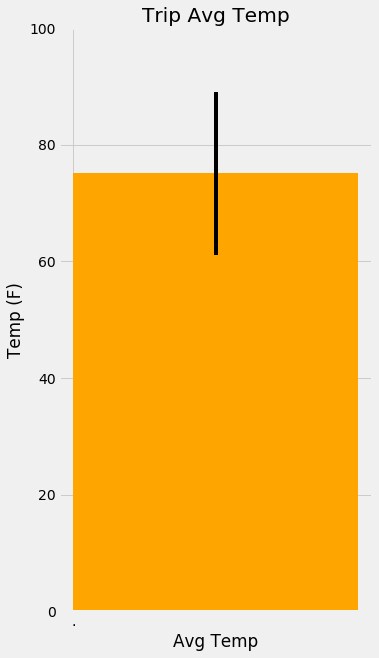

In [130]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(5,10));
plt.bar(x=".",height=tavg,yerr=tmax-tmin,color='orange',align="edge");
plt.ylim(0,100);
plt.xlabel("Avg Temp")
plt.ylabel("Temp (F)");
plt.title("Trip Avg Temp");

In [145]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

columns = [Station.station, Station.name, func.sum(Measurement.prcp), Station.latitude, Station.longitude, Station.elevation]

last_year_data =    session.query(*columns).\
                    group_by(Measurement.station).\
                    join(Station, Measurement.station==Station.station).\
                    filter(Measurement.date >= last_year_trip_start).filter(Measurement.date <= last_year_trip_end).all()

finaldata=pd.DataFrame(last_year_data,columns=["Station","Station_Name", "Total_Rainfall", "Latitude", "Longtitude", "Elevation"]
            ).sort_values("Total_Rainfall",ascending=False)
finaldata

,Station,Station_Name,Total_Rainfall,Latitude,Longtitude,Elevation
3,USC00516128,"MANOA LYON ARBO 785.2, HI US",4.02,21.33310,-157.80250,152.4
5,USC00519281,"WAIHEE 837.5, HI US",1.15,21.45167,-157.84889,32.9
1,USC00513117,"KANEOHE 838.1, HI US",0.67,21.42340,-157.80150,14.6
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.31,21.52130,-157.83740,7.0
7,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.23,21.33556,-157.71139,19.5
0,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",0.20,21.31520,-157.99920,0.9
6,USC00519397,"WAIKIKI 717.2, HI US",0.08,21.27160,-157.81680,3.0
4,USC00517948,"PEARL CITY, HI US",0.01,21.39340,-157.97510,11.9


In [146]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [156]:
# calculate the daily normals for your trip

# Set the start and end date of the trip
# Use the start and end date to create a range of dates
start_date = dt.datetime.strptime(trip_start,'%Y-%m-%d')
end_date = dt.datetime.strptime(trip_end,'%Y-%m-%d') 
date_range = end_date - start_date
# push each tuple of calculations into a list called `normals`
normals = []

for i in range(date_range.days + 1):
    date = start_date + dt.timedelta(days=i)
    # Strip off the year and save a list of %m-%d strings
    month_day = dt.datetime.strftime(date,'%m-%d')
    normals.append(month_day)
    
# Loop through the list of %m-%d strings and calculate the normals for each date
normals_list = []
for date in normals:
    normals_list.append(daily_normals(date)[0])
    
normals_list

[(69.0, 76.01960784313725, 84.0),
 (66.0, 75.66666666666667, 83.0),
 (68.0, 75.66666666666667, 81.0),
 (69.0, 75.62711864406779, 81.0),
 (67.0, 75.40350877192982, 81.0),
 (69.0, 75.41379310344827, 81.0),
 (68.0, 74.59322033898304, 81.0),
 (69.0, 74.60344827586206, 80.0),
 (70.0, 75.44067796610169, 82.0),
 (68.0, 73.96491228070175, 85.0)]

In [159]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normal_df=pd.DataFrame(normals_list,columns=["tmin","tavg","tmax"],index=[normals])
normal_df


,tmin,tavg,tmax
06-11,69.0,76.019608,84.0
06-12,66.0,75.666667,83.0
06-13,68.0,75.666667,81.0
06-14,69.0,75.627119,81.0
06-15,67.0,75.403509,81.0
06-16,69.0,75.413793,81.0
06-17,68.0,74.593220,81.0
06-18,69.0,74.603448,80.0
06-19,70.0,75.440678,82.0
06-20,68.0,73.964912,85.0


Text(0.5, 1.0, 'Daily Normal')

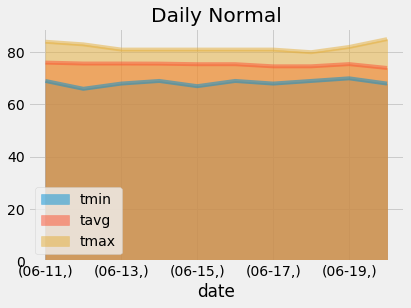

In [163]:
# Plot the daily normals as an area plot with `stacked=False`
normal_df.plot(kind="area",stacked=False);
plt.xlabel("date");
plt.title("Daily Normal")